In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
from ResNet import ResNet18
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 1. 数据准备
def prepare_data(batch_size=32):
    transform = transforms.Compose([
        transforms.Resize(224),  # 直接调整为224x224
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    val_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size)
    return train_loader, val_loader


In [3]:

def train_model(model, train_loader, val_loader, epochs=20, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay=1e-4) #l2正则
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # 动态学习率
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)  # 改用SGD
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 8], gamma=0.1)  # 阶梯式学习率
    
    
    best_val_acc = 0
    early_stop_counter = 0
    
    # 初始化记录器
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    for epoch in range(epochs):
        # 训练阶段
        model.train()
        train_loss, correct = 0, 0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            # 数据增强
            # inputs = transforms.RandomHorizontalFlip()(inputs)  # 随机水平翻转
            # inputs = transforms.ColorJitter(brightness=0.2, contrast=0.2)(inputs)
            
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()  # 更新学习率
            train_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                val_correct += (outputs.argmax(1) == labels).sum().item()
                
                 # 早停机制
            if val_correct/len(val_loader.dataset) > best_val_acc:
                best_val_acc = val_correct/len(val_loader.dataset)
                early_stop_counter = 0
                torch.save(model.state_dict(), 'best_model.pth')
            else:
                early_stop_counter += 1
                if early_stop_counter >= 3:  # 3轮无提升则停止
                    print("Early stopping triggered")
                    break
        
      
        
         
    # 修改记录指标部分
        history['train_acc'].append(correct/len(train_loader.dataset))
        history['val_acc'].append(val_correct/len(val_loader.dataset))

    # 修改打印部分
        print(f"\nTrain Loss: {train_loss/len(train_loader):.4f} | "
          f"Train Acc: {correct/len(train_loader.dataset)*100:.2f}%")
        print(f"Val Loss: {val_loss/len(val_loader):.4f} | "
          f"Val Acc: {val_correct/len(val_loader.dataset)*100:.2f}%")
            # 记录指标
        history['train_loss'].append(train_loss/len(train_loader))
        history['val_loss'].append(val_loss/len(val_loader))
 
        

    
    # 可视化训练过程
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Validation')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    scheduler.step(val_correct/len(val_loader.dataset))
        
       
    
    return history


cuda


Epoch 1/20: 100%|██████████| 1563/1563 [01:57<00:00, 13.26it/s]



Train Loss: 1.9550 | Train Acc: 31.49%
Val Loss: 1.5384 | Val Acc: 43.07%


Epoch 2/20: 100%|██████████| 1563/1563 [01:58<00:00, 13.23it/s]



Train Loss: 1.4466 | Train Acc: 46.89%
Val Loss: 1.2911 | Val Acc: 53.02%


Epoch 3/20: 100%|██████████| 1563/1563 [01:58<00:00, 13.20it/s]



Train Loss: 1.2019 | Train Acc: 56.68%
Val Loss: 1.0384 | Val Acc: 62.37%


Epoch 4/20: 100%|██████████| 1563/1563 [01:58<00:00, 13.19it/s]



Train Loss: 1.0039 | Train Acc: 64.43%
Val Loss: 0.9551 | Val Acc: 65.80%


Epoch 5/20: 100%|██████████| 1563/1563 [01:59<00:00, 13.04it/s]



Train Loss: 0.8698 | Train Acc: 69.47%
Val Loss: 0.8598 | Val Acc: 70.55%


Epoch 6/20: 100%|██████████| 1563/1563 [01:59<00:00, 13.08it/s]



Train Loss: 0.7602 | Train Acc: 73.33%
Val Loss: 0.7100 | Val Acc: 74.68%


Epoch 7/20: 100%|██████████| 1563/1563 [01:58<00:00, 13.19it/s]



Train Loss: 0.6694 | Train Acc: 76.59%
Val Loss: 0.6460 | Val Acc: 77.88%


Epoch 8/20: 100%|██████████| 1563/1563 [01:56<00:00, 13.36it/s]



Train Loss: 0.6034 | Train Acc: 79.00%
Val Loss: 0.6274 | Val Acc: 77.79%


Epoch 9/20: 100%|██████████| 1563/1563 [01:57<00:00, 13.34it/s]



Train Loss: 0.5469 | Train Acc: 81.05%
Val Loss: 0.5586 | Val Acc: 80.65%


Epoch 10/20: 100%|██████████| 1563/1563 [01:58<00:00, 13.24it/s]



Train Loss: 0.4968 | Train Acc: 82.85%
Val Loss: 0.5505 | Val Acc: 81.27%


Epoch 11/20: 100%|██████████| 1563/1563 [01:58<00:00, 13.20it/s]



Train Loss: 0.4596 | Train Acc: 84.05%
Val Loss: 0.5193 | Val Acc: 82.69%


Epoch 12/20: 100%|██████████| 1563/1563 [01:57<00:00, 13.35it/s]



Train Loss: 0.4300 | Train Acc: 85.18%
Val Loss: 0.4889 | Val Acc: 83.39%


Epoch 13/20: 100%|██████████| 1563/1563 [01:59<00:00, 13.06it/s]



Train Loss: 0.3990 | Train Acc: 86.22%
Val Loss: 0.4771 | Val Acc: 83.42%


Epoch 14/20: 100%|██████████| 1563/1563 [01:57<00:00, 13.28it/s]



Train Loss: 0.3683 | Train Acc: 87.15%
Val Loss: 0.4512 | Val Acc: 84.48%


Epoch 15/20: 100%|██████████| 1563/1563 [01:58<00:00, 13.24it/s]



Train Loss: 0.3439 | Train Acc: 88.17%
Val Loss: 0.4480 | Val Acc: 84.66%


Epoch 16/20: 100%|██████████| 1563/1563 [01:58<00:00, 13.17it/s]



Train Loss: 0.3199 | Train Acc: 88.97%
Val Loss: 0.4089 | Val Acc: 85.93%


Epoch 17/20: 100%|██████████| 1563/1563 [01:58<00:00, 13.23it/s]



Train Loss: 0.3018 | Train Acc: 89.48%
Val Loss: 0.4348 | Val Acc: 85.01%


Epoch 18/20: 100%|██████████| 1563/1563 [01:58<00:00, 13.21it/s]



Train Loss: 0.2838 | Train Acc: 90.14%
Val Loss: 0.4072 | Val Acc: 86.01%


Epoch 19/20: 100%|██████████| 1563/1563 [01:59<00:00, 13.10it/s]



Train Loss: 0.2638 | Train Acc: 90.78%
Val Loss: 0.4524 | Val Acc: 85.04%


Epoch 20/20: 100%|██████████| 1563/1563 [01:59<00:00, 13.04it/s]



Train Loss: 0.2455 | Train Acc: 91.62%
Val Loss: 0.4426 | Val Acc: 85.36%


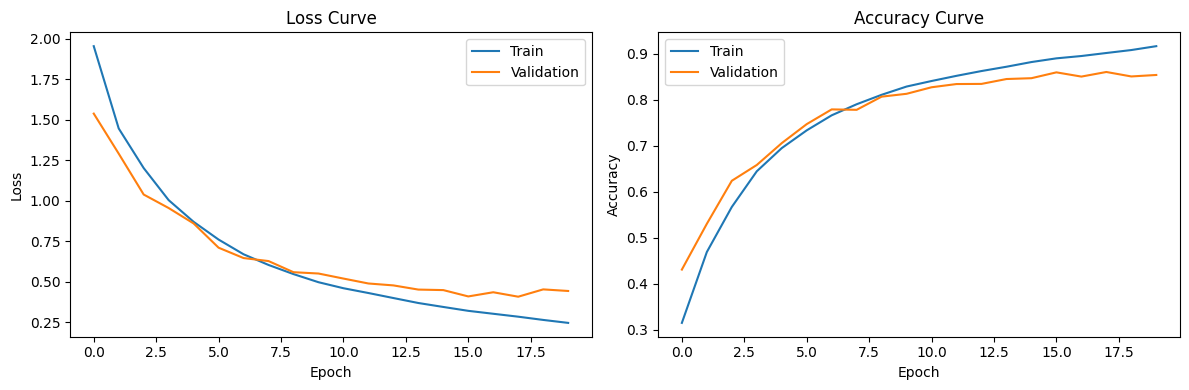

/root/miniconda3/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


{'train_loss': [1.9550359754782034,
  1.44658139815181,
  1.201940739109054,
  1.0038683645174584,
  0.8698179866553726,
  0.7601948504408277,
  0.6694191036434869,
  0.603364233807044,
  0.5468731887462196,
  0.49677296934300175,
  0.4596076896479705,
  0.43001291199193425,
  0.3990197136988643,
  0.36830698904686837,
  0.3438869348666985,
  0.3199018456222953,
  0.30180321584955594,
  0.28379564004654084,
  0.26377339989080384,
  0.24548031430946507],
 'train_acc': [0.31488,
  0.4689,
  0.56682,
  0.6443,
  0.69466,
  0.73326,
  0.76594,
  0.79,
  0.81052,
  0.82848,
  0.8405,
  0.85176,
  0.86216,
  0.8715,
  0.8817,
  0.88974,
  0.8948,
  0.90136,
  0.90778,
  0.9162],
 'val_loss': [1.5383558227612188,
  1.2910622819163167,
  1.0383998509793997,
  0.9550814563854815,
  0.859773467333553,
  0.7099937353842556,
  0.6459993120199575,
  0.6273606647127352,
  0.5585901159733629,
  0.5504915522405515,
  0.5193060764584678,
  0.4888854786610832,
  0.4770731073313247,
  0.4512396410060005,

In [4]:
model = ResNet18(num_classes=10)
train_loader, val_loader = prepare_data()
    
 # 开始训练
train_model(model, train_loader, val_loader, epochs=20)